# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 45555276441929183
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1213093880012693422
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Fri Dec 17 16:06:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    34W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'InceptionV3'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 5
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2", "S3", "S4"
T_all_labels = "T0", "T1", "T2", "T3", "T4"

#base_path = ''
base_path = 'gdrive/My Drive/Research_5_1_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_InceptionV3_None S_InceptionV3_imagenet T_InceptionV3_None T_InceptionV3_imagenet


['S_InceptionV3_imagenet',
 'S_InceptionV3_None',
 'T_InceptionV3_imagenet',
 'T_InceptionV3_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2274, 128, 128, 3) (2274, 1)
(758, 128, 128, 3) (758, 1)
(758, 128, 128, 3) (758, 1)

(2034, 128, 128, 3) (2034, 1)
(678, 128, 128, 3) (678, 1)
(678, 128, 128, 3) (678, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2274, 128, 128, 3) (2274, 5)
(758, 128, 128, 3) (758, 5)
(758, 128, 128, 3) (758, 5)

(2034, 128, 128, 3) (2034, 5)
(678, 128, 128, 3) (678, 5)
(678, 128, 128, 3) (678, 5)


## 2-2. Image Check

xTrain_S image Numbers :  2274
xTrain_S image Numbers // 10 :  227
11


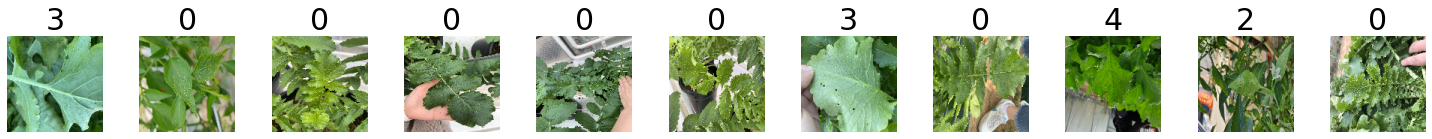

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  2034
xTrain_S image Numbers // 10 :  203
11


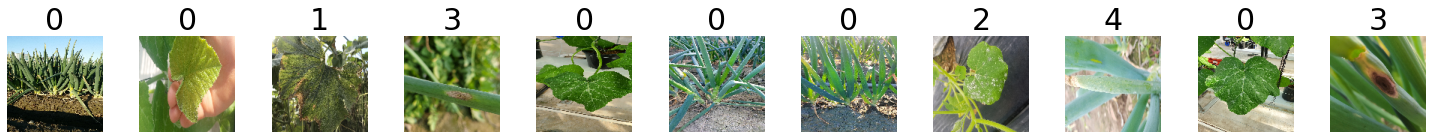

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.InceptionV3 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.InceptionV3 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
36/36 [==============================] - 25s 221ms/step - loss: 1.0869 - accuracy: 0.5677 - val_loss: 1.5995 - val_accuracy: 0.2111
Epoch 2/100
36/36 [==============================] - 4s 125ms/step - loss: 0.7102 - accuracy: 0.7357 - val_loss: 2.6099 - val_accuracy: 0.2111
Epoch 3/100
36/36 [==============================] - 4s 119ms/step - loss: 0.5992 - accuracy: 0.7788 - val_loss: 3.8057 - val_accuracy: 0.2111
Epoch 4/100
36/36 [==============================] - 4s 124ms/step - loss: 0.5058 - accuracy: 0.8144 - val_loss: 2.2733 - val_accuracy: 0.2124
Epoch 5/100
36/36 [==============================] - 4s 124ms/step - loss: 0.4172 - accuracy: 0.8342 - val_loss: 2.0408 - val_accuracy: 0.2164
Epoch 6/100
36/36 [==============================] - 4s 124ms/step - loss: 0.3751 - accuracy: 0.8531 - val_loss: 1.8778 - val_accuracy: 0.2441
Epoch 7/100
36/36 [==============================] - 4s 120ms/step - loss: 0.3363 - accuracy: 0.8729 - val_loss: 4.7143 - val_accuracy: 0.125

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.086940,0.567722,1.599493,0.211082
1,0.710218,0.735708,2.609867,0.211082
2,0.599153,0.778804,3.805668,0.211082
3,0.505837,0.814424,2.273264,0.212401
4,0.417176,0.834213,2.040812,0.216359
...,...,...,...,...
70,0.030910,0.990325,2.452049,0.597625
71,0.047767,0.984169,1.239105,0.730871
72,0.064494,0.977133,4.230363,0.800792
73,0.025001,0.993404,1.981684,0.741425


Minimum validation loss: 0.6017112731933594
Maximum validation accuracy: 0.8693931102752686


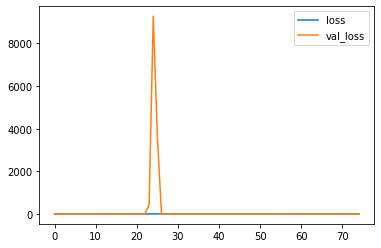

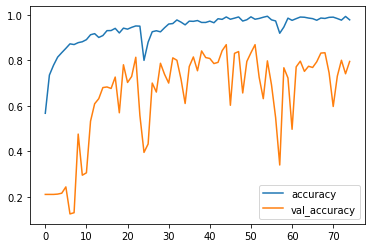

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
24/24 [==============================] - 1s 38ms/step - loss: 0.6426 - accuracy: 0.8628
test loss, test acc: [0.6426017880439758, 0.8627968430519104]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

24/24 [==============================] - 2s 24ms/step


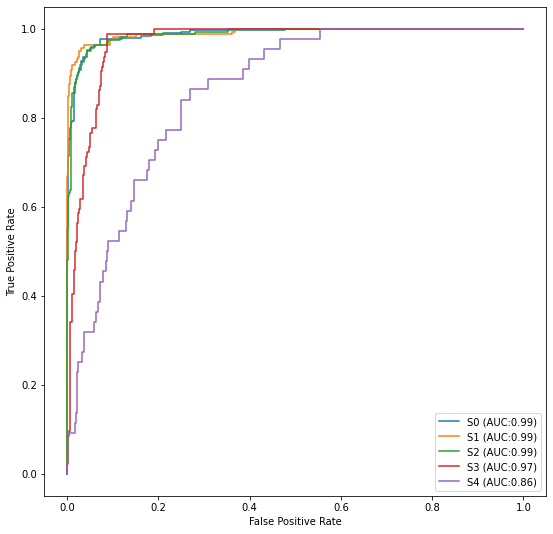

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

87924736/87910968 [==============================] - 1s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
36/36 [==============================] - 14s 171ms/step - loss: 0.6864 - accuracy: 0.7489 - val_loss: 34.8412 - val_accuracy: 0.2098
Epoch 2/100
36/36 [==============================] - 4s 123ms/step - loss: 0.3429 - accuracy: 0.8791 - val_loss: 4.6223 - val_accuracy: 0.4406
Epoch 3/100
36/36 [==============================] - 4s 123ms/step - loss: 0.2501 - accuracy: 0.9059 - val_loss: 83.2325 - val_accuracy: 0.5937
Epoch 4/100
36/36 [==============================] - 4s 123ms/step - loss: 0.1381 - accuracy: 0.9490 - val_loss: 11.0718 - val_accuracy: 0.6847
Epoch 5/100
36/36 [==============================] - 4s 119ms/step - loss: 0.1095 - accuracy: 0.9617 - val_loss: 2.4756 - val_accuracy: 0.6530
Epoch 6/100
36/36 [==============================] - 4s 119ms/step - loss: 0.1910 - accuracy: 0.9393 - val_loss: 8.2212 - val_accuracy: 0.5528
Epoch 7/100
36/36 [==============================] - 4s 119ms/step - loss: 0.2126 - accuracy: 0.9296 - val_loss: 1150.1293 - val_accuracy:

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.686408,0.748901,34.841236,0.209763
1,0.342862,0.879068,4.622270,0.440633
2,0.250106,0.905893,83.232529,0.593668
3,0.138069,0.948989,11.071820,0.684697
4,0.109488,0.961741,2.475572,0.653034
5,0.190970,0.939314,8.221226,0.552770
6,0.212611,0.929639,1150.129272,0.306069
7,0.173454,0.943712,523.668274,0.349604
8,0.126278,0.961741,1.685682,0.670185
9,0.120131,0.959982,1.283643,0.781003


Minimum validation loss: 0.3615225553512573
Maximum validation accuracy: 0.9129287600517273


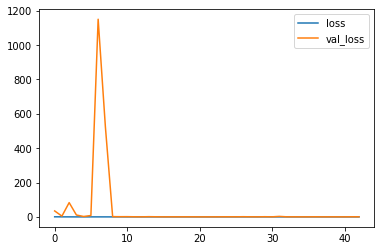

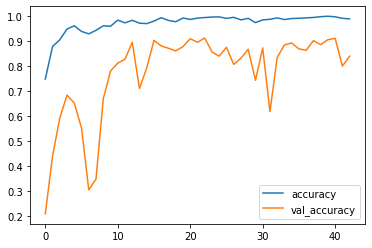

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
24/24 [==============================] - 1s 27ms/step - loss: 0.5068 - accuracy: 0.9024
test loss, test acc: [0.5067687034606934, 0.9023746848106384]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

24/24 [==============================] - 2s 24ms/step


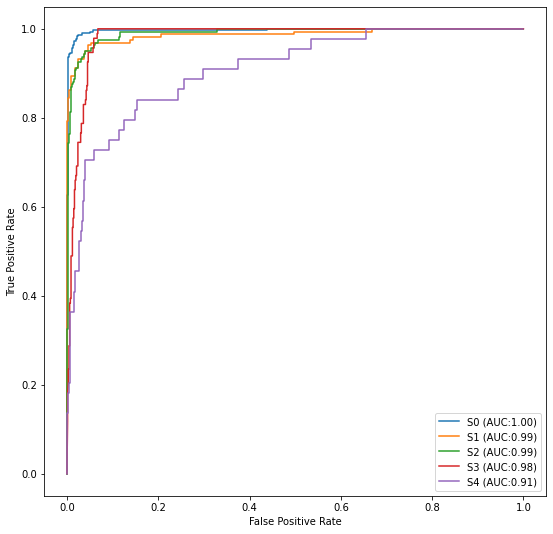

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
32/32 [==============================] - 15s 222ms/step - loss: 0.9333 - accuracy: 0.6598 - val_loss: 1.7497 - val_accuracy: 0.1386
Epoch 2/100
32/32 [==============================] - 4s 119ms/step - loss: 0.4834 - accuracy: 0.8245 - val_loss: 3.3304 - val_accuracy: 0.0619
Epoch 3/100
32/32 [==============================] - 4s 120ms/step - loss: 0.3767 - accuracy: 0.8717 - val_loss: 3.5077 - val_accuracy: 0.0649
Epoch 4/100
32/32 [==============================] - 4s 120ms/step - loss: 0.3576 - accuracy: 0.8746 - val_loss: 6.1669 - val_accuracy: 0.0649
Epoch 5/100
32/32 [==============================] - 4s 120ms/step - loss: 0.2734 - accuracy: 0.9046 - val_loss: 5.3836 - val_accuracy: 0.0664
Epoch 6/100
32/32 [==============================] - 4s 120ms/step - loss: 0.2208 - accuracy: 0.9184 - val_loss: 6.6856 - val_accuracy: 0.1386
Epoch 7/100
32/32 [==============================] - 4s 120ms/step - loss: 0.2258 - accuracy: 0.9243 - val_loss: 4.9160 - val_accuracy: 0.091

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.933279,0.659784,1.749715,0.138643
1,0.483379,0.824484,3.330367,0.061947
2,0.376671,0.871681,3.507710,0.064897
3,0.357595,0.874631,6.166860,0.064897
4,0.273423,0.904621,5.383581,0.066372
...,...,...,...,...
73,0.056479,0.978368,0.256765,0.930678
74,0.034506,0.988692,0.258610,0.921829
75,0.087619,0.972960,0.305155,0.911504
76,0.044453,0.986726,0.398587,0.896755


Minimum validation loss: 0.19584286212921143
Maximum validation accuracy: 0.9513274431228638


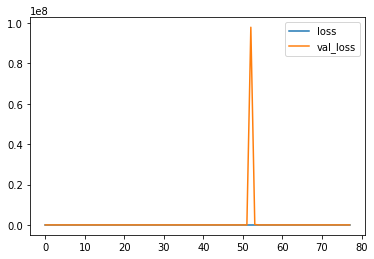

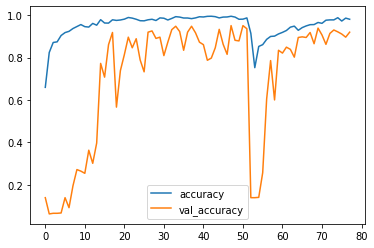

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
22/22 [==============================] - 1s 37ms/step - loss: 0.2358 - accuracy: 0.9366
test loss, test acc: [0.23576007783412933, 0.9365781545639038]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

22/22 [==============================] - 2s 24ms/step


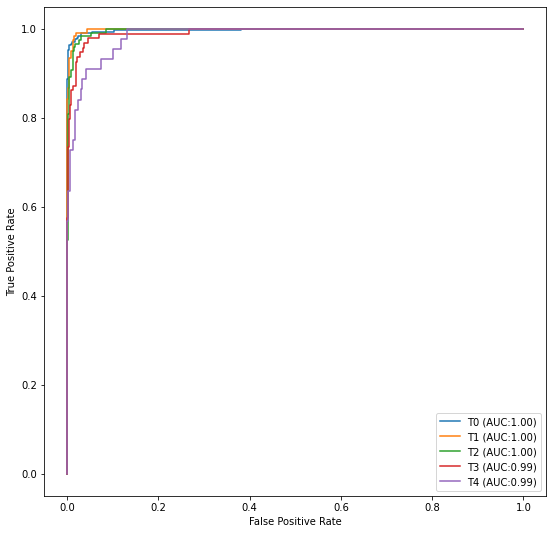

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
32/32 [==============================] - 13s 178ms/step - loss: 0.6123 - accuracy: 0.7837 - val_loss: 73.0971 - val_accuracy: 0.4425
Epoch 2/100
32/32 [==============================] - 4s 118ms/step - loss: 0.2177 - accuracy: 0.9184 - val_loss: 18.2050 - val_accuracy: 0.4425
Epoch 3/100
32/32 [==============================] - 4s 124ms/step - loss: 0.1541 - accuracy: 0.9479 - val_loss: 3.2885 - val_accuracy: 0.6475
Epoch 4/100
32/32 [==============================] - 4s 123ms/step - loss: 0.1142 - accuracy: 0.9641 - val_loss: 1.4371 - val_accuracy: 0.7330
Epoch 5/100
32/32 [==============================] - 4s 122ms/step - loss: 0.1002 - accuracy: 0.9671 - val_loss: 0.4124 - val_accuracy: 0.9263
Epoch 6/100
32/32 [==============================] - 4s 118ms/step - loss: 0.0984 - accuracy: 0.9794 - val_loss: 0.9705 - val_accuracy: 0.8407
Epoch 7/100
32/32 [==============================] - 4s 118ms/step - loss: 0.0726 - accuracy: 0.9779 - val_loss: 0.7230 - val_accuracy: 0.8

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.612341,0.783677,73.097130,0.442478
1,0.217740,0.918387,18.204983,0.442478
2,0.154103,0.947886,3.288549,0.647493
3,0.114239,0.964110,1.437144,0.733038
4,0.100206,0.967060,0.412365,0.926254
...,...,...,...,...
76,0.030417,0.992625,0.525824,0.855457
77,0.018022,0.995575,0.229880,0.958702
78,0.023518,0.994100,0.091900,0.974926
79,0.029021,0.992625,0.127223,0.964602


Minimum validation loss: 0.04247734323143959
Maximum validation accuracy: 0.991150438785553


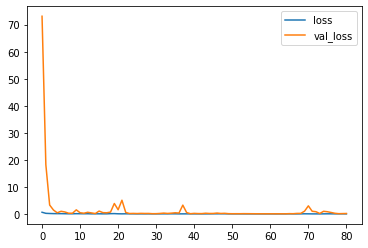

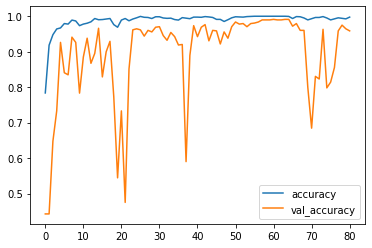

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
22/22 [==============================] - 1s 27ms/step - loss: 0.0697 - accuracy: 0.9853
test loss, test acc: [0.06970804184675217, 0.98525071144104]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

22/22 [==============================] - 2s 24ms/step


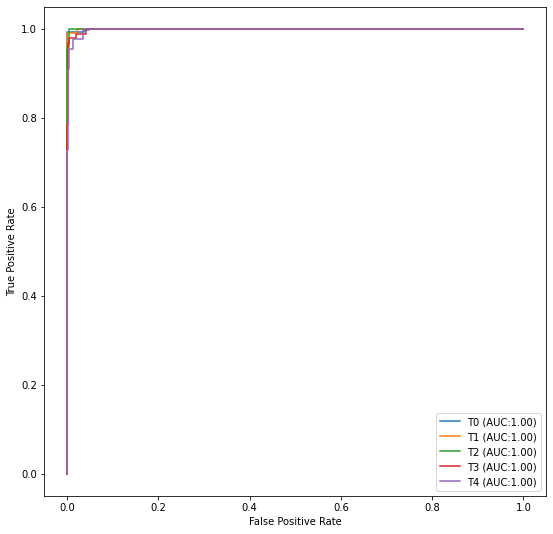

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_InceptionV3_None
test loss, test acc: [0.6426017880439758, 0.8627968430519104]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_InceptionV3_imagenet
test loss, test acc: [0.5067687034606934, 0.9023746848106384]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_InceptionV3_None
test loss, test acc: [0.23576007783412933, 0.9365781545639038]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_InceptionV3_imagenet
test loss, test acc: [0.06970804184675217, 0.98525071144104]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_InceptionV3_None →→→ Target Test
22/22 [==============================] - 1s 28ms/step - loss: 4.5421 - accuracy: 0.3687
test loss, test acc: [4.542064666748047, 0.3687315583229065]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_InceptionV3_imagenet →→→ Target Test
22/22 [==============================] - 1s 27ms/step - loss: 4.5970 - accuracy: 0.2684
test loss, test acc: [4.597038269042969, 0.26843658089637756]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_InceptionV3_None →→→ Source Test
24/24 [==============================] - 1s 27ms/step - loss: 5.0087 - accuracy: 0.2375
test loss, test acc: [5.008747577667236, 0.23746702075004578]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_InceptionV3_imagenet →→→ Source Test
24/24 [==============================] - 1s 27ms/step - loss: 4.6928 - accuracy: 0.2388
test loss, test acc: [4.692784309387207, 0.23878628015518188]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )